In [3]:
import importlib
import utils
import visualization
importlib.reload(utils)
importlib.reload(visualization)
%reload_ext autoreload
%autoreload 2
from utils import *
from visualization import visualize
pd.set_option('display.max_colwidth', None)


In [4]:
excel_path = "/home/viktoria/Downloads/ARBOLES ALIMENTOS EJERCICIO KABELLI.xlsx"
grouped_confident, grouped_review = process_excel_for_duplicates_and_split_by_company(
    excel_path,
    confidence_threshold=93,
    low_confidence_threshold=88
)

# now lets count unique products not cases

grouped_confident_prod = pairs_to_unique_products(grouped_confident)
grouped_review_prod = pairs_to_unique_products(grouped_review)

for company, df in grouped_confident_prod.items():
    print(f"--- Confident matches for {company} ---")
    print(df.shape[0])

for company, df in grouped_review_prod.items():
    print(f"--- Needs review matches for {company} ---")
    print(df.shape[0])

--- Confident matches for Surtiventas Arbol_24_25 ---
36
--- Confident matches for PRISA Arbol_24_25 ---
17
--- Confident matches for Prinorte Arbol_24_25 ---
7
--- Confident matches for Prisur Arbol_24_25 ---
37
--- Needs review matches for Surtiventas Arbol_24_25 ---
16
--- Needs review matches for PRISA Arbol_24_25 ---
11
--- Needs review matches for Prinorte Arbol_24_25 ---
4
--- Needs review matches for Prisur Arbol_24_25 ---
18


In [5]:
# Correct cases with same and different names
data = load_all_sheets(excel_path)

correct_products = find_similar_products(data, 50, different_sku=False)
correct_products = correct_products.copy()
correct_products = remove_flavor_variants(correct_products)
columns_to_show = [col for col in correct_products.columns if col not in ['Numbers 1', 'Numbers 2']]
correct_products = correct_products.loc[:, columns_to_show]
exact_matches = correct_products[correct_products['Similarity'] == 100]
partial_matches = correct_products[correct_products['Similarity'] < 100]
grouped_exact, grouped_partial = split_matches_by_company(exact_matches, partial_matches)

# unique products

grouped_exact_prod = pairs_to_unique_products(grouped_exact)
grouped_partial_prod = pairs_to_unique_products(grouped_partial)

# Print or explore
for company, df in grouped_exact_prod.items():
    print(f"\n--- Exact matches for {company} ---")
    print(df.shape[0])

for company, df in grouped_partial_prod.items():
    print(f"\n--- Partial matches for {company} ---")
    print(df.shape[0])



--- Exact matches for Surtiventas Arbol_24_25 ---
168

--- Exact matches for Prinorte Arbol_24_25 ---
79

--- Exact matches for PRISA Arbol_24_25 ---
41

--- Exact matches for Prisur Arbol_24_25 ---
198

--- Partial matches for Surtiventas Arbol_24_25 ---
209

--- Partial matches for Prinorte Arbol_24_25 ---
60

--- Partial matches for PRISA Arbol_24_25 ---
107

--- Partial matches for Prisur Arbol_24_25 ---
193


In [6]:
grouped_partial["Prinorte Arbol_24_25"].tail(20)

,Marca,Nombre SKU 1,SKU 1,Sheet 1,Nombre SKU 2,SKU 2,Sheet 2,Similarity
546,HAITI,CAFE GRANO MOLIDO 2.5 HAITI MEZCLA SUP/MOKA 250GR,83995,PRISA Arbol_24_25,CAFE 250 GR HAITI SUPER MOKA 2.5 MOLIDO.,83995,Prinorte Arbol_24_25,80
549,SUPREMO,TE HIERBAS DP X 20 UN CEDRON SUPREMO,11479,Surtiventas Arbol_24_25,TE HIERBAS SUPREMO X 20 BOLSITAS CEDRON,11479,Prinorte Arbol_24_25,80
552,SUPREMO,HIERBA SUPREMO 20 BL SURTIDOS,84484,PRISA Arbol_24_25,TE HIERBAS SUPREMO X 20 BOLSITAS SURTIDAS,84484,Prinorte Arbol_24_25,80
557,SUPREMO,TE DP X 100 UN PREMIUM SUPREMO.,21900,Surtiventas Arbol_24_25,TE SUPREMO PREMIUM X 100 BOLSITAS,21900,Prinorte Arbol_24_25,79
565,NESTLE,CAFE 170 GR NESCAFE POLVO TRADICIONAL TARRO,99840,Prinorte Arbol_24_25,CAFE 170 GR NESCAFE TRADICIONAL LATA,99840,Prisur Arbol_24_25,78
573,LOBOS,SAL 1 KG LOBOS FINA MESA BOLSA,82766,Surtiventas Arbol_24_25,SAL DE MESA 1 KG LOBOS,82766,Prinorte Arbol_24_25,77
574,COSTA,CEREAL BARRA COSTA GOLDEN CEREAL X 20 UNDS,36035,PRISA Arbol_24_25,CEREAL BARRA COSTA CHOCOLATE X 20 UDS,36035,Prinorte Arbol_24_25,76
584,SUPREMO,TE DP X 100 UN CEYLAN ORO SUPREMO.,17111,Surtiventas Arbol_24_25,TE SUPREMO CEYLAN LINEA ORO X 100 BOLSITAS,17111,Prinorte Arbol_24_25,75
586,CACHAMATE,YERBA MATE 500 GR CACHAMATE POLEO-MANZ-HIN ARG.,52118,Prinorte Arbol_24_25,YERBA MATE 500 GR CACHAMATE POLEO MANZA.HINOJO,52118,Prisur Arbol_24_25,74
597,COSTA,CEREAL BARRA COSTA FRUTAS + YOGURT X 20 UDS,36035,PRISA Arbol_24_25,CEREAL BARRA COSTA CHOCOLATE X 20 UDS,36035,Prinorte Arbol_24_25,72


In [8]:

all_companies = set(grouped_confident) | set(grouped_review) | set(grouped_exact) | set(grouped_partial)
all_companies = list(all_companies)

company_shapes = {}
for company in all_companies:
    review_shape = grouped_review_prod.get(company, pd.DataFrame()).shape
    confident_shape = grouped_confident_prod.get(company, pd.DataFrame()).shape
    exact_shape = grouped_exact_prod.get(company, pd.DataFrame()).shape
    partial_shape = grouped_partial_prod.get(company, pd.DataFrame()).shape

    company_shapes[company] = [review_shape[0], confident_shape[0], exact_shape[0], partial_shape[0]]



In [9]:

filtered= find_normal_cases(excel_path)


In [11]:
company_shapes


{'Surtiventas Arbol_24_25': [16, 36, 168, 209, 285],
 'Prisur Arbol_24_25': [18, 37, 198, 193, 156],
 'PRISA Arbol_24_25': [11, 17, 41, 107, 330],
 'Prinorte Arbol_24_25': [4, 7, 79, 60, 61]}

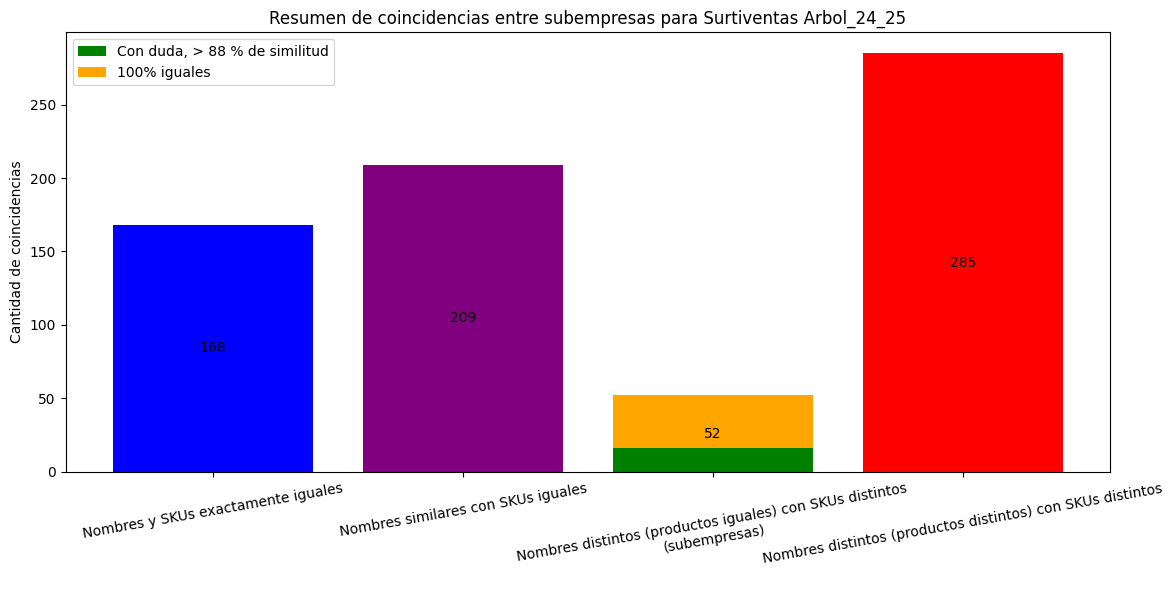

In [32]:
#  special cases devided by 2 because each product appears 2 times - for each subsompany, but normal cases are unique
company = "Surtiventas Arbol_24_25"
review, confident, exact, partial, other = company_shapes[company]
visualize(review, confident, exact, partial, other, company)



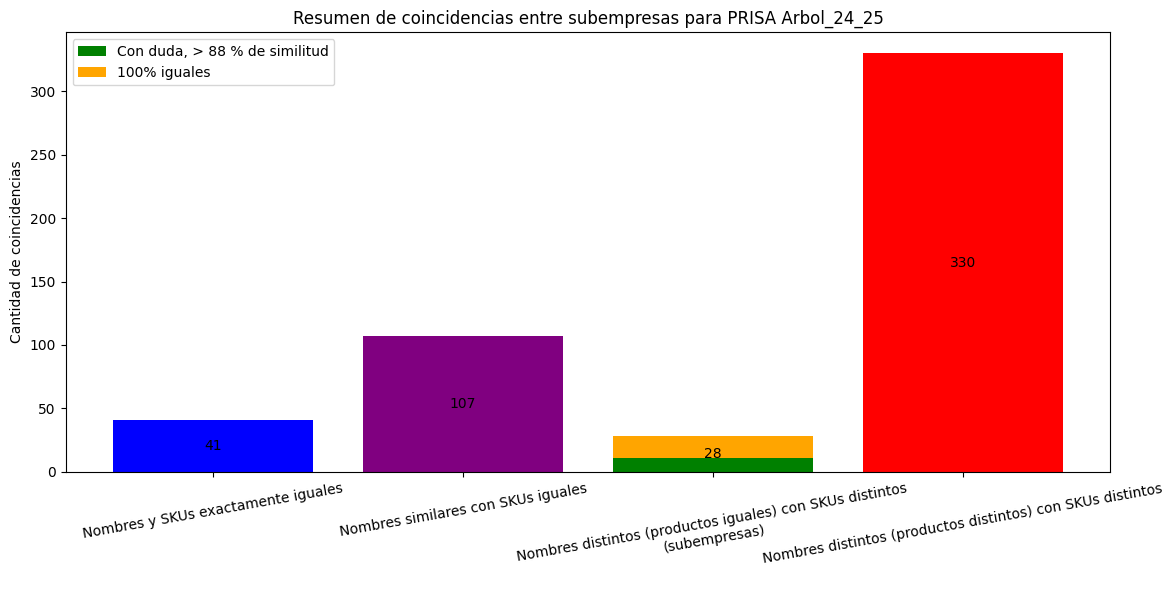

In [33]:
company = "PRISA Arbol_24_25"
review, confident, exact, partial, other = company_shapes[company]

visualize(review, confident, exact, partial, other, company)

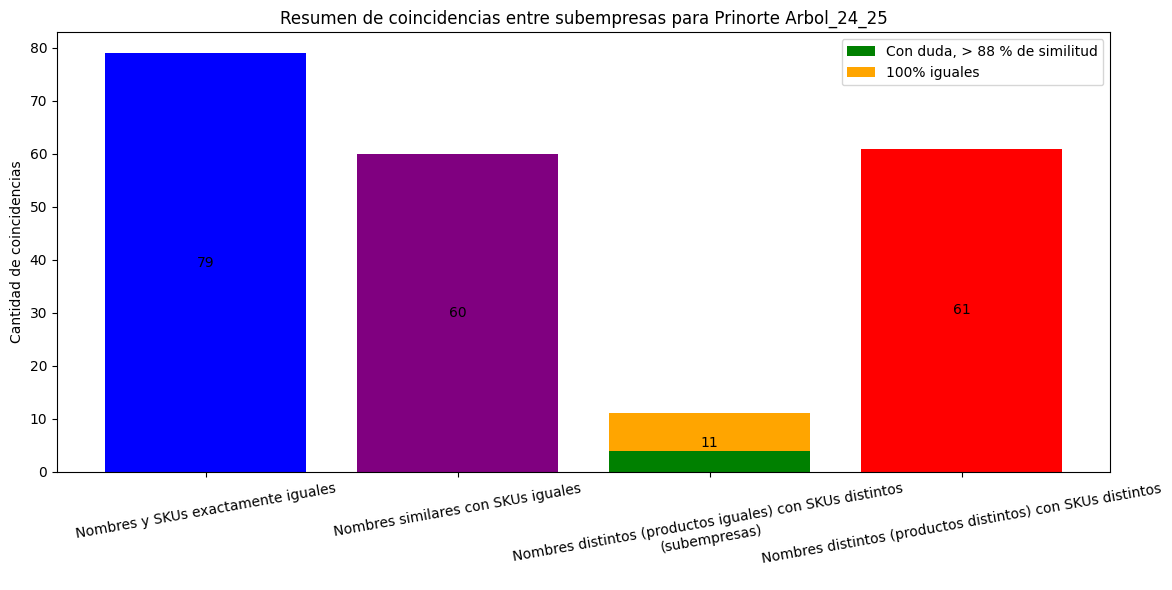

In [34]:
company = "Prinorte Arbol_24_25"
review, confident, exact, partial, other = company_shapes[company]

visualize(review, confident, exact, partial, other, company)

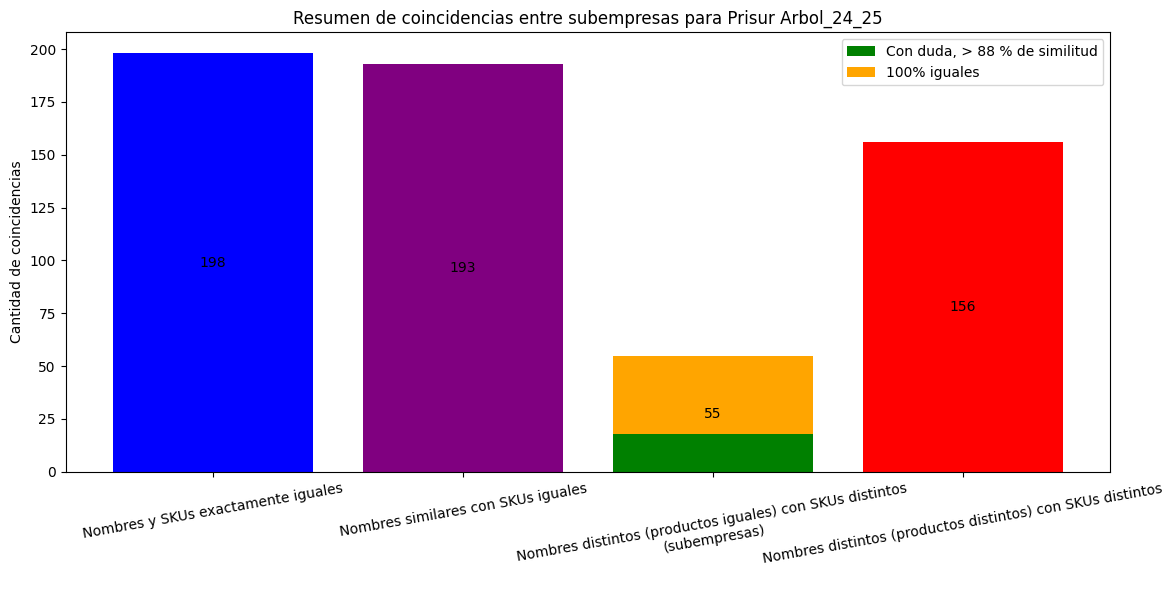

In [35]:
company = "Prisur Arbol_24_25"
review, confident, exact, partial, other = company_shapes[company]

visualize(review, confident, exact, partial, other, company)

### Excel para subempresas

In [21]:
excel_path = "/home/viktoria/Downloads/ARBOLES ALIMENTOS EJERCICIO KABELLI.xlsx"
grouped_confident, grouped_review = process_excel_for_duplicates_and_split_by_company(
    excel_path,
    confidence_threshold=93,
    low_confidence_threshold=50
)

confident, needs_review = process_excel_for_duplicates(
    excel_path,
    confidence_threshold=93,
    low_confidence_threshold=50
)
# Correct cases with same and different names
data = load_all_sheets(excel_path)

correct_products = find_similar_products(data, 50, different_sku=False)
correct_products = correct_products.copy()
correct_products = remove_flavor_variants(correct_products)
columns_to_show = [col for col in correct_products.columns if col not in ['Numbers 1', 'Numbers 2']]
correct_products = correct_products.loc[:, columns_to_show]
exact_matches = correct_products[correct_products['Similarity'] == 100]
partial_matches = correct_products[correct_products['Similarity'] < 100]
grouped_exact, grouped_partial = split_matches_by_company(exact_matches, partial_matches)



In [43]:

filtered= find_normal_cases(excel_path)
filtered = filtered.rename(columns={"Sheet": "Subempresa"})


filtered_subempresas = {
    sub: filtered[filtered["Subempresa"] == sub].reset_index(drop=True)
    for sub in filtered["Subempresa"].unique()
}


In [44]:
filtered.shape


(1097, 4)

In [33]:

exact_matches = exact_matches.copy()
exact_matches['class'] = "same names, same SKU"
partial_matches = partial_matches.copy()
partial_matches['class'] = "similar name, same SKU"
confident = confident.copy()
confident['class'] = "same or similar name, different products"
needs_review = needs_review.copy()
needs_review['class'] = "similar name, probably different products"

relevant_cols = ['Marca', 'Nombre SKU 1', 'SKU 1', 'Sheet 1',
                 'Nombre SKU 2', 'SKU 2', 'Sheet 2', 'Similarity', 'class']

def filter_columns(df):
    return df[[col for col in relevant_cols if col in df.columns]]

combined_df = pd.concat([
    filter_columns(exact_matches),
    filter_columns(partial_matches),
    filter_columns(confident),
    filter_columns(needs_review)
], ignore_index=True)

combined_df = combined_df.rename(columns={
    'Sheet 1': 'Subempresa 1',
    'Sheet 2': 'Subempresa 2'
})


In [34]:
combined_df.head()

,Marca,Nombre SKU 1,SKU 1,Subempresa 1,Nombre SKU 2,SKU 2,Subempresa 2,Similarity,class
0,BELMONT,ACEITE COCINA 250 CC. VEGETAL BELMONT,79094,Surtiventas Arbol_24_25,ACEITE COCINA 250 CC. VEGETAL BELMONT,79094,Prinorte Arbol_24_25,100,"same names, same SKU"
1,DUL-SUC,ENDULZANTE DUL-SUC CON STEVIA LIQUIDO 270 ML,88250,Prinorte Arbol_24_25,ENDULZANTE DUL-SUC CON STEVIA LIQUIDO 270 ML,88250,Prisur Arbol_24_25,100,"same names, same SKU"
2,NESTLE,LECHE CONDENSADA 397 GR NESTLE,21708,PRISA Arbol_24_25,LECHE CONDENSADA 397 GR NESTLE,21708,Prisur Arbol_24_25,100,"same names, same SKU"
3,NESTLE,CREMA DE LECHE NESTLE 236 GR,21849,Surtiventas Arbol_24_25,CREMA DE LECHE 236 GR NESTLE,21849,Prisur Arbol_24_25,100,"same names, same SKU"
4,NESTLE,LECHE CONDENSADA 397 GRS. NESTLE,21708,Surtiventas Arbol_24_25,LECHE CONDENSADA 397 GRS. NESTLE,21708,Prinorte Arbol_24_25,100,"same names, same SKU"


In [35]:

all_subempresas = pd.unique(
    combined_df[['Subempresa 1', 'Subempresa 2']].values.ravel()
)

subempresa_tables = {
    sub: combined_df[
        (combined_df['Subempresa 1'] == sub) | (combined_df['Subempresa 2'] == sub)
    ].reset_index(drop=True)
    for sub in all_subempresas
}


In [37]:
subempresa_tables.keys()

dict_keys(['Surtiventas Arbol_24_25', 'Prinorte Arbol_24_25', 'Prisur Arbol_24_25', 'PRISA Arbol_24_25'])

In [47]:
import os
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

for sub in filtered_subempresas:
    filtered_subempresas[sub]['class'] = "unique name, sku"

output_dir = "/home/viktoria/Downloads/prisa/"
os.makedirs(output_dir, exist_ok=True)

output_columns = [
    'Marca', 'Nombre SKU 1', 'SKU 1', 'Subempresa 1',
    'Nombre SKU 2', 'SKU 2', 'Subempresa 2', 'Similarity', 'class'
]

class_colors = {
    "same names, same SKU":        PatternFill(start_color="CCE5FF", fill_type="solid"),  # light blue
    "similar name, same SKU":      PatternFill(start_color="E5CCFF", fill_type="solid"),  # light purple
    "same or similar name, different products": PatternFill(start_color="CCFFCC", fill_type="solid"),  # light green
    "similar name, probably different products": PatternFill(start_color="FFFFCC", fill_type="solid"),  # light yellow
    "unique name, sku":            PatternFill(start_color="FFCCCC", fill_type="solid")   # light red
}

for subempresa, df in subempresa_tables.items():
    filtered_rows = filtered_subempresas.get(subempresa, pd.DataFrame())
    if not filtered_rows.empty:
        filtered_rows = filtered_rows.rename(columns={
            "Nombre SKU": "Nombre SKU 1",
            "SKU": "SKU 1",
            "Subempresa": "Subempresa 1"
        })
        for col in output_columns:
            if col not in filtered_rows.columns:
                filtered_rows[col] = None
        filtered_rows = filtered_rows[output_columns]

    final_df = pd.concat([df, filtered_rows], ignore_index=True)

    safe_name = subempresa.replace("/", "_").replace("\\", "_").replace(" ", "_")
    file_path = os.path.join(output_dir, f"{safe_name}_with_classes.xlsx")
    final_df.to_excel(file_path, index=False)

    wb = load_workbook(file_path)
    ws = wb.active

    class_col = output_columns.index('class') + 1

    for row in range(2, ws.max_row + 1):
        class_value = ws.cell(row=row, column=class_col).value
        if class_value in class_colors:
            fill = class_colors[class_value]
            for col in range(1, ws.max_column + 1):
                ws.cell(row=row, column=col).fill = fill

    wb.save(file_path)




In [48]:
from openpyxl import load_workbook

filtered_combined = filtered.copy()
filtered_combined = filtered_combined.rename(columns={
    "Nombre SKU": "Nombre SKU 1",
    "SKU": "SKU 1",
    "Subempresa": "Subempresa 1"
})
filtered_combined["class"] = "unique name, sku"

for col in output_columns:
    if col not in filtered_combined.columns:
        filtered_combined[col] = None

filtered_combined = filtered_combined[output_columns]
final_combined_df = pd.concat([combined_df, filtered_combined], ignore_index=True)

file_path = os.path.join(output_dir, f"all_companies_with_classes.xlsx")
final_combined_df.to_excel(file_path, index=False)

wb = load_workbook(file_path)
ws = wb.active

class_col = output_columns.index('class') + 1  # 1-based index

for row in range(2, ws.max_row + 1):
    class_value = ws.cell(row=row, column=class_col).value
    if class_value in class_colors:
        fill = class_colors[class_value]
        for col in range(1, ws.max_column + 1):
            ws.cell(row=row, column=col).fill = fill

wb.save(file_path)
